![bigquery_ui](bigquery_ui.png)

The Datasets window opens.
2.In the Search bar, type "NYC bike" then press Enter.
3.One result NYC Citi Bike Trips is returned. Click on the 
dataset name and then View Dataset.

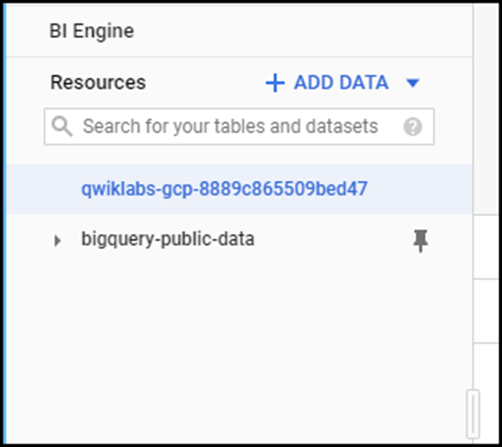

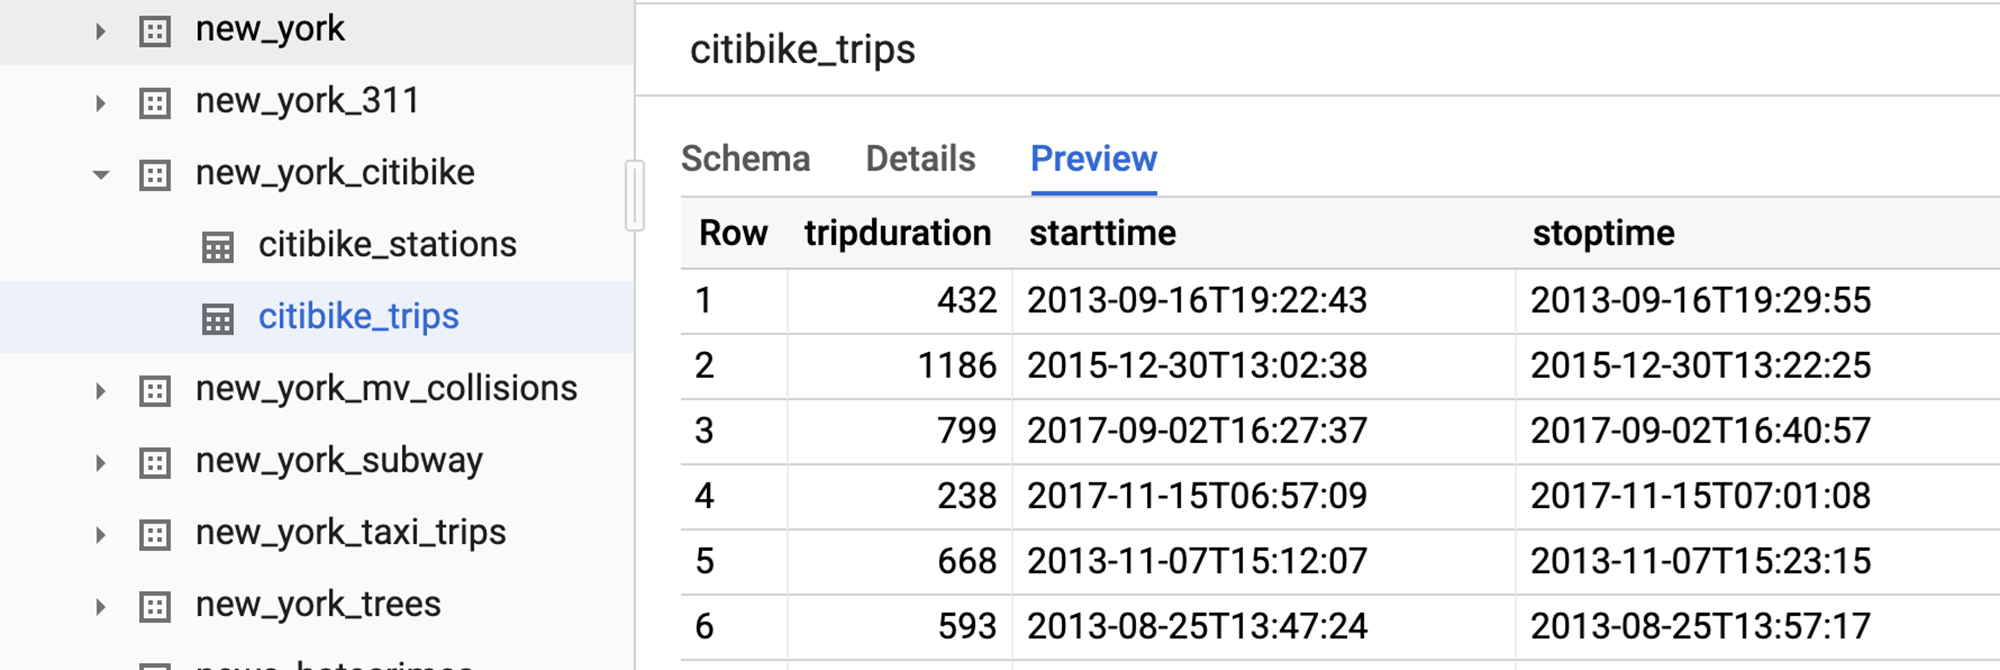

In [ ]:
-- ( typical duration for the 10 most common 
-- one-way rentals)

SELECT
MIN(start_station_name) AS start_station_name,
MIN(end_station_name) AS end_station_name,
APPROX_QUANTILES(tripduration, 10)[OFFSET (5)] AS 
typical_duration,
COUNT(tripduration) AS num_trips
FROM
`bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
start_station_id != end_station_id
GROUP BY
start_station_id,
end_station_id
ORDER BY
num_trips DESC
LIMIT
10

In [ ]:
-- total distance travelled by each bicycle in the dataset. 
-- Note that the query limits the results to only top 5
WITH
trip_distance AS (
SELECT
bikeid,
ST_Distance(ST_GeogPoint(s.longitude,
s.latitude),
ST_GeogPoint(e.longitude,
e.latitude)) AS distance
FROM
`bigquery-public-data.new_york_citibike.citibike_trips`,
`bigquery-public-data.new_york_citibike.citibike_stations` as s,
`bigquery-public-data.new_york_citibike.citibike_stations` as e
WHERE
start_station_id = s.station_id
AND end_station_id = e.station_id )
SELECT
bikeid,
SUM(distance)/1000 AS total_distance
FROM
trip_distance
GROUP BY
bikeid
ORDER BY total_distance DESC
LIMIT 5

### Access to the weather dataset
In the left pane of the BigQuery Console, select the newly added bigquery-public-data project and 
select ghcn_d > ghcnd_2015. Then click on the Preview tab. Your console should resemble the following:
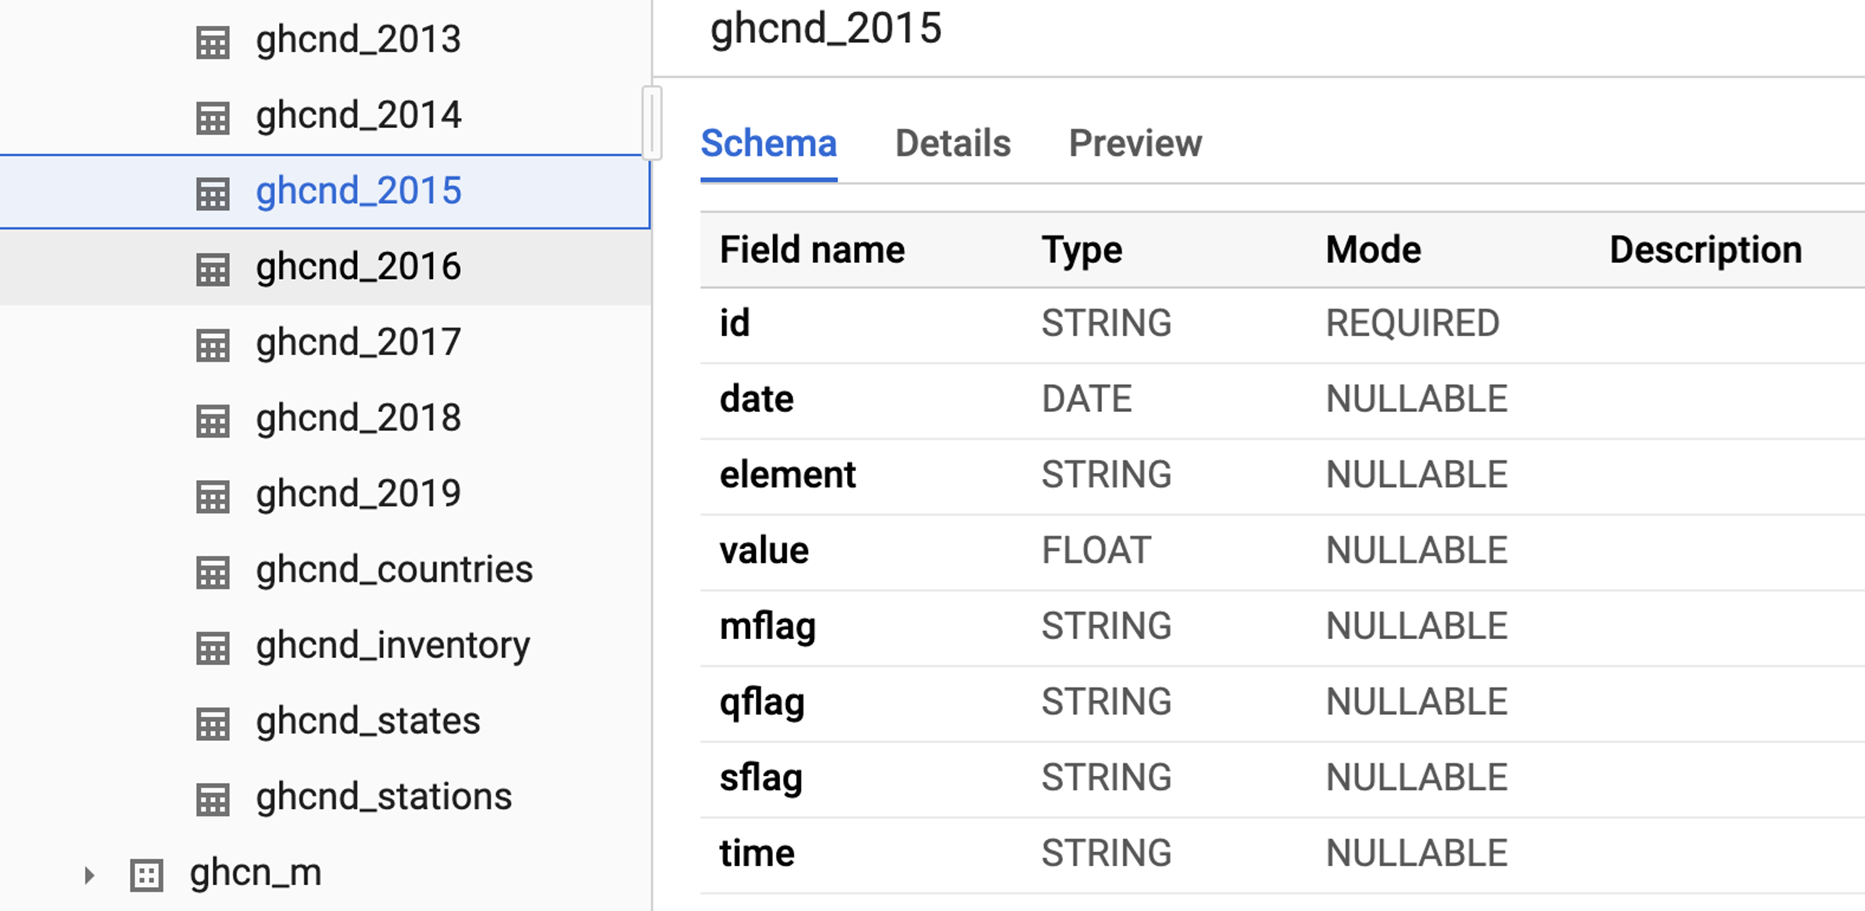

In [ ]:
-- rainfall (in mm) for all days in 2015 from a weather station 
-- in New York whose id is provided in the query

SELECT
wx.date,
wx.value/10.0 AS prcp
FROM
`bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
id = 'USW00094728'
AND qflag IS NULL
AND element = 'PRCP'
ORDER BY
wx.date


In [ ]:
-- Explore data (Find correlation between rain and bicycle rentals)
WITH bicycle_rentals AS (
SELECT
COUNT(starttime) as num_trips,
EXTRACT(DATE from starttime) as trip_date
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY trip_date
),
rainy_days AS
(
SELECT
date,
(MAX(prcp) > 5) AS rainy
FROM (
SELECT
wx.date AS date,
IF (wx.element = 'PRCP', wx.value/10, NULL) AS prcp
FROM
`bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
wx.id = 'USW00094728'
)
GROUP BY
date
)
Explore data (Find correlation between rain and bicycle rentals)
SELECT
ROUND(AVG(bk.num_trips)) AS num_trips,
wx.rainy
FROM bicycle_rentals AS bk
JOIN rainy_days AS wx
ON wx.date = bk.trip_date
GROUP BY wx.rainy

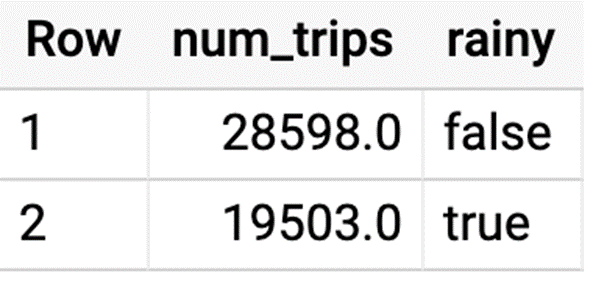